In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from layers.QConv2D import QConv2D
from circuits.random import ry_random
from utils.plotter import *
from data.datahandler import datahandler
from data.datareader import datareader

import pennylane as qml
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os

## Load dataset

In [3]:
dhandler = datahandler(os.path.join('datasets', 'EuroSAT'))
dhandler.print_report(name = 'EuroSAT')

Dataset EuroSAT

Class 0 - Forest               - #images: 3000
Class 1 - River                - #images: 2500
Class 2 - Highway              - #images: 2500
Class 3 - AnnualCrop           - #images: 3000
Class 4 - SeaLake              - #images: 3000
Class 5 - HerbaceousVegetation - #images: 3000
Class 6 - Industrial           - #images: 2500
Class 7 - Residential          - #images: 3000
Class 8 - PermanentCrop        - #images: 2500
Class 9 - Pasture              - #images: 2000


In [4]:
subA, subB = dhandler.split(None, 0.2)
dhandler.print_report(subA, name='Training Split')
dhandler.print_report(subB, name='Validation Split')

Dataset Training Split

Class 0 - Forest               - #images: 2400
Class 1 - River                - #images: 2000
Class 2 - Highway              - #images: 2000
Class 3 - AnnualCrop           - #images: 2400
Class 4 - SeaLake              - #images: 2400
Class 5 - HerbaceousVegetation - #images: 2400
Class 6 - Industrial           - #images: 2000
Class 7 - Residential          - #images: 2400
Class 8 - PermanentCrop        - #images: 2000
Class 9 - Pasture              - #images: 1600
Dataset Validation Split

Class 0 - Forest               - #images: 600
Class 1 - River                - #images: 500
Class 2 - Highway              - #images: 500
Class 3 - AnnualCrop           - #images: 600
Class 4 - SeaLake              - #images: 600
Class 5 - HerbaceousVegetation - #images: 600
Class 6 - Industrial           - #images: 500
Class 7 - Residential          - #images: 600
Class 8 - PermanentCrop        - #images: 500
Class 9 - Pasture              - #images: 400


In [5]:
labels_mapper, x_train, y_train = dhandler.unpack(subA)
labels_mapper, x_val,   y_val   = dhandler.unpack(subB)

print('Dataset Size')
print('Training   --- {}'.format(len(x_train)))
print('Validation --- {}'.format(len(x_val)))

print('\nTraining Dataset samples')
print('X Train --- {} '.format(x_train[0]))
print('Y Train --- {} '.format(y_train[0]))

Dataset Size
Training   --- 21600
Validation --- 5400

Training Dataset samples
X Train --- datasets/EuroSAT/Forest/Forest_864.jpg 
Y Train --- [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 


In [6]:
data, metadata = datareader.load(x_train[0])

In [7]:
(x, y) = next(iter(datareader.generator((x_train, y_train), 16, (64,64,3))))

In [8]:
d = {}
for i, (x,y) in enumerate(datareader.generator((x_train, y_train), 1, (64,64,3))):
    if i >= len(x_train):
        break
    
    d['C{}'.format(np.argmax(y))] += 1
    

KeyError: 'C3'

## Define Quantum Circuit 

In [30]:
QUBITS      = 9
KERNEL_SIZE = 3
FILTERS     = 6
N_LAYERS    = 1
STRIDE      = 2
NUM_JOBS    = 8

In [31]:
circuit = ry_random(QUBITS, KERNEL_SIZE, FILTERS, N_LAYERS)

In [32]:
drawer = qml.draw(circuit)
print(drawer(np.random.rand(QUBITS)))

0: ──RY(2.45)─╭RandomLayers(M0)─┤  <Z>
1: ──RY(2.93)─├RandomLayers(M0)─┤  <Z>
2: ──RY(0.55)─├RandomLayers(M0)─┤  <Z>
3: ──RY(2.42)─├RandomLayers(M0)─┤  <Z>
4: ──RY(1.94)─├RandomLayers(M0)─┤  <Z>
5: ──RY(2.88)─├RandomLayers(M0)─┤  <Z>
6: ──RY(1.77)─├RandomLayers(M0)─┤     
7: ──RY(1.67)─├RandomLayers(M0)─┤     
8: ──RY(0.71)─╰RandomLayers(M0)─┤     


## Quantum Convolutional 2D layer

In [33]:
conv1 = QConv2D(
    ry_random(QUBITS, KERNEL_SIZE, FILTERS, N_LAYERS),
    FILTERS, 
    KERNEL_SIZE, 
    STRIDE, 
    NUM_JOBS
)

In [34]:
(x, y) = next(iter(datareader.generator((x_train, y_train), 1, (64,64,3))))
img = x[0]
out1 = conv1.apply(img, verbose = True)

  0%|          | 0/31 [00:00<?, ?it/s]

In [35]:
print('Image shape       ', img.shape)
print('QuaConv2D L1 shape', out1.shape)

Image shape        (64, 64, 3)
QuaConv2D L1 shape (31, 31, 6)


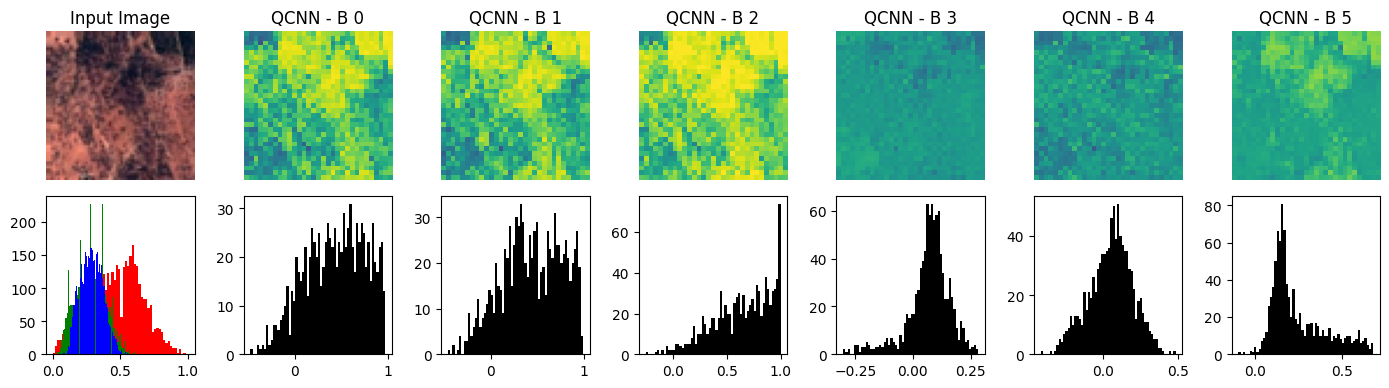

In [36]:
plot_result(img, out1)